In [23]:
%pip install kaggle pandas numpy matplotlib seaborn scikit-learn tensorflow tensorflow-macos tensorflow-metal

import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout

import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
TensorFlow version: 2.16.2
Num GPUs Available:  1


### Project Description
#### NLP Disaster Detection Mini Project

##### Step 1: Brief description of the problem and data
Our goal is to try to accurately identify real disasters in tweets.  This is a binary clasification problem, which we will attempt to use Recurrant Neural Networks to solve.

We are using the nlp-getting-started database from Kaggle.  The data has the following columns:
- id - a unique identifier for each tweet
- text - the text of the tweet
- location - the location the tweet was sent from (may be blank)
- keyword - a particular keyword from the tweet (may be blank)
- target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

(Source: Kaggle)

We will import that dataset below:

In [2]:
# Download the dataset

# Uncomment if re-download is needed
# !kaggle competitions download -c nlp-getting-started

# with zipfile.ZipFile('nlp-getting-started.zip', 'r') as zip_ref:
#     zip_ref.extractall('data')

target
0    4342
1    3271
Name: count, dtype: int64


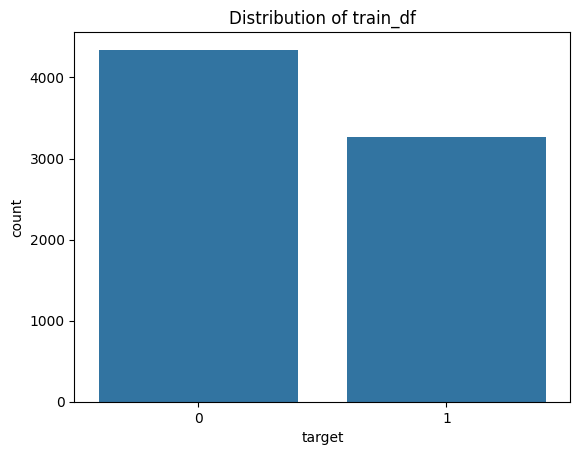

Missing values:
 id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
Duplicate values: 0
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


In [26]:
# Part 2: Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

# Inspect labels
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
print(train_df['target'].value_counts())

# What is the distribution of positive/negative cases?
sns.countplot(x='target', data=train_df)
plt.title('Distribution of train_df')
plt.show()



# Are there any missing values?
missing_values = train_df.isnull().sum()
print('Missing values:\n', missing_values)

# Are there any duplicates?
duplicate_values = train_df.duplicated().sum()
print('Duplicate values:', duplicate_values)

# Preview train_df
print(train_df.head())

In [27]:
# The first step is the tokenize the words in the dataset.

max_words = 10000 # Started with 25,000 words, but saw overfitting, reduced to 10k
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>') # Create Tokenizer, use <00V> when words are out-of-vocabulary
tokenizer.fit_on_texts(train_df['text']) # fit tokenizer based on training data
word_index = tokenizer.word_index # Create mapping of integer to dictionary word

# Convert the text data to tokenized sequences
train_sequences = tokenizer.texts_to_sequences(train_df['text'])
test_sequences = tokenizer.texts_to_sequences(test_df['text'])

# In order to make all of the tweets the same shape, we will pad tweets that are shorter than the max
max_len = 50
X_train = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
X_test = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X_train, train_df['target'], test_size=0.2, random_state=42)

In [28]:
# Create the model

model = Sequential([ # Simple sequential NN
    # Creates a dense vector in 25000th dimensional space representing semantic similarities of words
    Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
    SimpleRNN(64, return_sequences=True), # Create a RNN layer with 64 Neurons
    Dropout(0.5), # Create dropout to avoid overfitting
    SimpleRNN(64), # 2nd RNN layer
    Dense(1, activation='sigmoid') # output layer
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/Users/mark/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_13 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_14 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Now that the model is created let's fit the model

history = model.fit(X_train, y_train, epochs=25, batch_size=64, validation_data=(X_val, y_val))

val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {val_accuracy}')

Epoch 1/25


2024-07-01 19:47:47.404167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


96/96 ━━━━━━━━━━━━━━━━━━━━ 96s 990ms/step - accuracy: 0.6230 - loss: 0.6490 - val_accuracy: 0.7840 - val_loss: 0.4834
Epoch 2/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 96s 997ms/step - accuracy: 0.8967 - loss: 0.2906 - val_accuracy: 0.7807 - val_loss: 0.5741
Epoch 3/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 96s 997ms/step - accuracy: 0.9705 - loss: 0.0921 - val_accuracy: 0.7564 - val_loss: 0.6574
Epoch 4/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 94s 982ms/step - accuracy: 0.9780 - loss: 0.0618 - val_accuracy: 0.7636 - val_loss: 0.7527
Epoch 5/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 93s 964ms/step - accuracy: 0.9849 - loss: 0.0411 - val_accuracy: 0.7209 - val_loss: 0.9767
Epoch 6/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 93s 972ms/step - accuracy: 0.9866 - loss: 0.0384 - val_accuracy: 0.7761 - val_loss: 0.8794
Epoch 7/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 2125s 22s/step - accuracy: 0.9846 - loss: 0.0400 - val_accuracy: 0.7190 - val_loss: 0.8893
Epoch 8/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 1096s 12s/step - accuracy: 0.9919 - loss: 0.0266 - val_accuracy: 0.740

In [7]:
model.save('rnn1.keras')

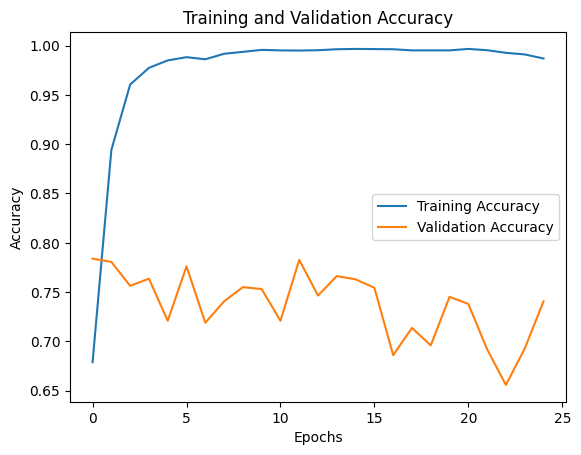

In [8]:
# Let's check how the accuracy changed over each epoch

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


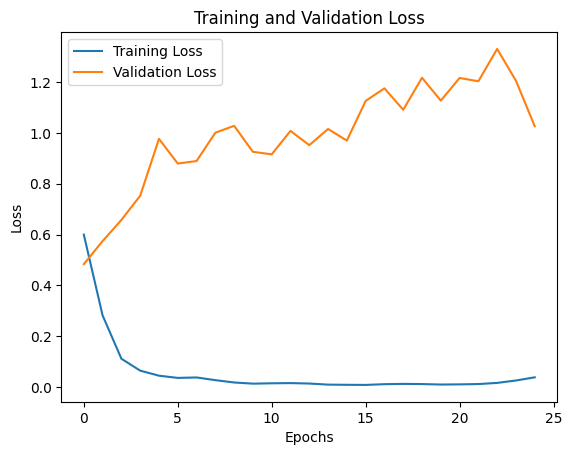

In [9]:
# Loss function over time

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [13]:
# Modified model with different hyperparameters

model2 = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=100), # Smaller embedding layer
    SimpleRNN(32, return_sequences=True, kernel_regularizer=l2(0.001)), # Less units in RNN with L2 regularization
    Dropout(0.5),
    SimpleRNN(32, kernel_regularizer=l2(0.001)), # add L2 reg and less units
    Dropout(0.5),
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)) # add L2 reg
])

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) # early stopping callback
history2 = model2.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/15


/Users/mark/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.5549 - loss: 0.7893 - val_accuracy: 0.7610 - val_loss: 0.5993
Epoch 2/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.8185 - loss: 0.5197 - val_accuracy: 0.7676 - val_loss: 0.6063
Epoch 3/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 96s 999ms/step - accuracy: 0.9144 - loss: 0.3297 - val_accuracy: 0.7820 - val_loss: 0.6729
Epoch 4/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 96s 998ms/step - accuracy: 0.9635 - loss: 0.2000 - val_accuracy: 0.7531 - val_loss: 0.7408


In [ ]:
model2.save('rnn2.keras')

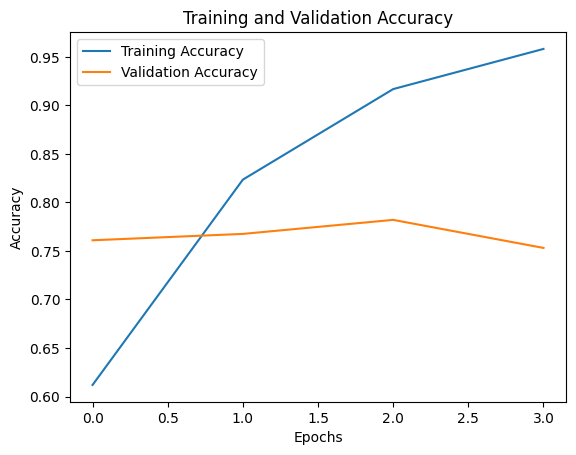

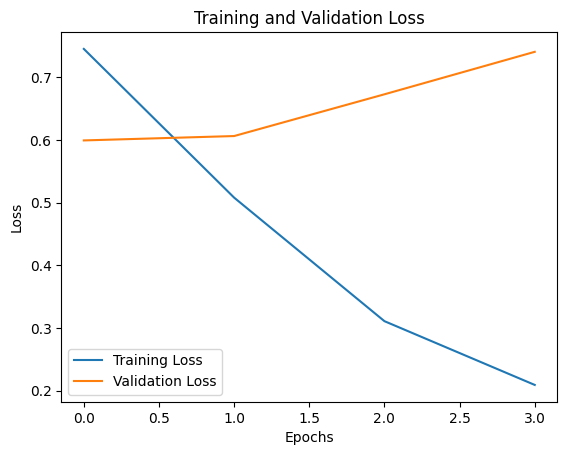

In [14]:
train_accuracy2 = history2.history['accuracy']
val_accuracy2 = history2.history['val_accuracy']

plt.plot(train_accuracy2, label='Training Accuracy')
plt.plot(val_accuracy2, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

train_loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

plt.plot(train_loss2, label='Training Loss')
plt.plot(val_loss2, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [20]:
# The above model ended early because the accuracy increase fairly quickly, but the val_accuracy was not improving

# Modified model with different hyperparameters

model3 = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len), # Smaller embedding layer
    SimpleRNN(32, kernel_regularizer=l2(0.001)), # Less units in RNN with L2 regularization
    Dropout(0.5),
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)) # add L2 reg
])

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Add early stopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) # early stopping callback
history3 = model3.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/10


/Users/mark/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 50s 506ms/step - accuracy: 0.5853 - loss: 0.7167 - val_accuracy: 0.7610 - val_loss: 0.5709
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 48s 499ms/step - accuracy: 0.8655 - loss: 0.4201 - val_accuracy: 0.7643 - val_loss: 0.5405
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 48s 500ms/step - accuracy: 0.9520 - loss: 0.2074 - val_accuracy: 0.7466 - val_loss: 0.6501
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 47s 494ms/step - accuracy: 0.9803 - loss: 0.1161 - val_accuracy: 0.6986 - val_loss: 0.8414
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 48s 496ms/step - accuracy: 0.9788 - loss: 0.1095 - val_accuracy: 0.7472 - val_loss: 0.7840
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 48s 496ms/step - accuracy: 0.9901 - loss: 0.0688 - val_accuracy: 0.7341 - val_loss: 0.8408
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 47s 490ms/step - accuracy: 0.9915 - loss: 0.0610 - val_accuracy: 0.7190 - val_loss: 0.8713
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 48s 495ms/step - accuracy: 0.9931 - loss: 0.0515 - val_accuracy: 0.728

In [21]:
model3.save('rnn3.keras')

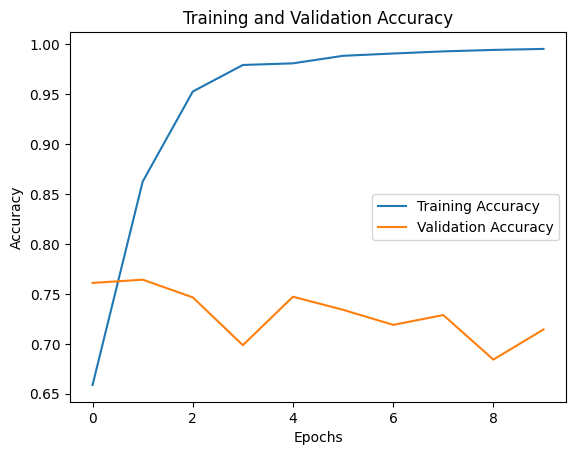

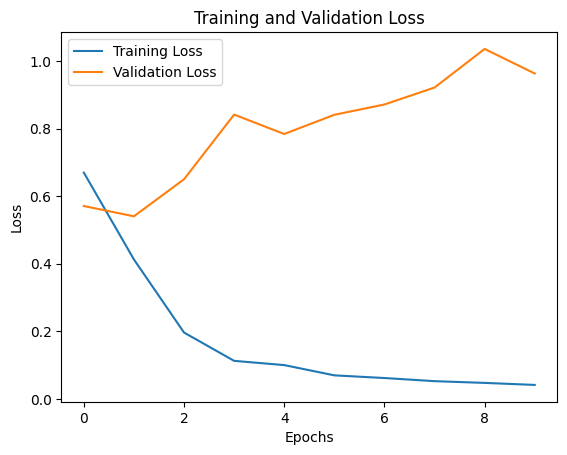

In [22]:
train_accuracy3 = history3.history['accuracy']
val_accuracy3 = history3.history['val_accuracy']

plt.plot(train_accuracy3, label='Training Accuracy')
plt.plot(val_accuracy3, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

train_loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

plt.plot(train_loss3, label='Training Loss')
plt.plot(val_loss3, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [35]:
# Try new model using LSTM

model4 = Sequential([
    Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
    LSTM(16, return_sequences=True, kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    LSTM(16, kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))
])

optimizer = Adam(learning_rate=0.001)
model4.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

history4 = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])


Epoch 1/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step - accuracy: 0.9644 - loss: 0.0992 - val_accuracy: 0.7617 - val_loss: 0.7546 - learning_rate: 2.0000e-04
Epoch 2/15
12/96 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - accuracy: 0.9711 - loss: 0.0803

KeyboardInterrupt: 

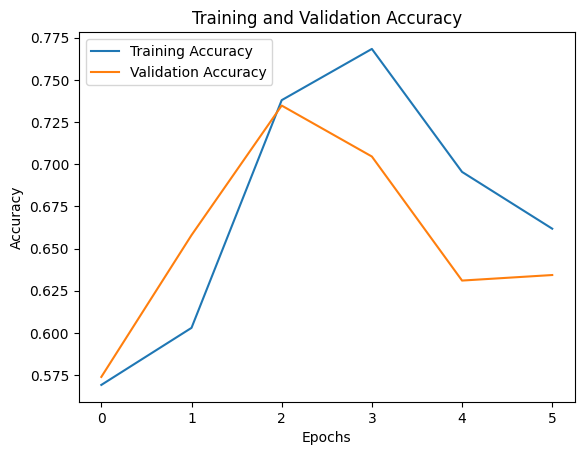

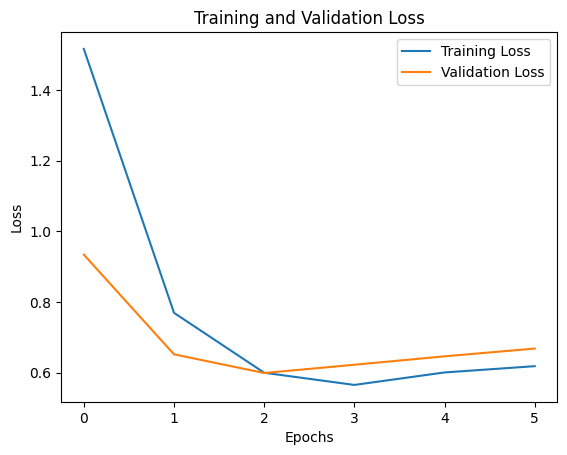

In [31]:
model4.save('rnn4.keras')

train_accuracy4 = history4.history['accuracy']
val_accuracy4 = history4.history['val_accuracy']

plt.plot(train_accuracy4, label='Training Accuracy')
plt.plot(val_accuracy4, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

train_loss4 = history4.history['loss']
val_loss4 = history4.history['val_loss']

plt.plot(train_loss4, label='Training Loss')
plt.plot(val_loss4, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Analysis

Above you'll find that I attempted a few different model architectures, hyperparameters, and techniques, including the use of early_stopping, regularization, different learning rates, dropout layers, etc.  In most cases the model was fairly quick to fit for the training set, but performed poorly on the validation set.  While it's not entirely clear what the main issue contributing to this is, the model is still able to predict on the validation set with around 70% accuracy.

In the future, I'd like to go deeper with RNNs and understand how each of these elements affect the results, but this is challenging considering each attempt at fitting the model can take several hours, even with a powerful GPU.

In [36]:
test_predictions = model4.predict(X_test)
test_predictions = (test_predictions > 0.5).astype(int)

submission_df = pd.read_csv('data/sample_submission.csv')
submission_df['target'] = test_predictions
submission_df.to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
